In [1]:
import pandas as pd

dataset = 'assistments2009'
# dataset = 'duolingo'

df = pd.read_csv(f'../data/{dataset}/data.csv')

N_SKILLS = df['skill'].max()+1

In [2]:
n = df['user'].nunique()
prop_train = 0.5
n_train = int(n * prop_train)

In [3]:
n_train

2081

In [4]:
import numpy as np

np.random.seed(42)
user_train = np.random.choice(df['user'].unique(), size=n_train, replace=False)
user_train[:10]

array([1664,  251,  129,   83,  839,  830, 3024, 2871, 2950, 3281])

In [5]:
# use stored train dataset to ensure determinism regardless of machine
df_train = df[df['user'].isin(user_train)]
df_train = pd.read_csv(f'../data/{dataset}_train/data.csv')
user_train = df_train['user'].unique()
df_train, df_train['user'].nunique()

(        user    item  skill  correct  wins  fails
 0       2099   76429     90        0     0      0
 1       2099   76430     90        1     0      1
 2       2099   76431     90        1     1      1
 3       2099   76432     90        1     2      1
 4       2099   76433     90        0     3      1
 ...      ...     ...    ...      ...   ...    ...
 140180   488  135605      6        1     5      1
 140181   488  135607      6        1     6      1
 140182   488  135601      6        1     7      1
 140183   488  135602      6        1     8      1
 140184   488  135616      6        1     9      1
 
 [140185 rows x 6 columns],
 2081)

In [6]:
train_users = sorted(df_train['user'].unique())
train_users[:10], len(train_users)

([3, 5, 6, 7, 9, 10, 11, 12, 14, 15], 2081)

In [7]:
def anonymize(df, p=0.1):
    df_anon = df.sample(frac=1-p, random_state=42).sort_index().reset_index(drop=True)
    return df_anon

In [8]:
def df_to_seq(df):
    return {
        user_id: [tuple(x) for x in user[['skill', 'correct']].to_numpy()]
        #[tuple(x) for x in user[['item_id', 'skill_id', 'correct']].to_numpy()]
        for user_id, user in df.groupby('user')
    }
seq = df_to_seq(df)
seq[list(seq.keys())[0]][:8], seq[list(seq.keys())[1]][:8]

([(81, 0), (81, 1), (81, 0), (81, 1), (81, 1), (83, 1), (82, 1), (83, 1)],
 [(38, 1), (38, 1), (81, 0), (81, 1), (81, 1), (81, 1), (8, 0), (8, 0)])

In [9]:
# More sophisticated baseline than drop, not used in the paper
def combine(df, spread=1.0):
    data = []
    seq = df_to_seq(df)
    lengths = {}
    for s in seq.values():
        l = len(s)
        if l not in lengths:
            lengths[l] = 0
        lengths[l] += 1
    L = sum(lengths.values())
    for l in lengths.keys():
        lengths[l] /= L
    users = list(seq.keys())
    up = np.array([len(seq[user]) for user in users])
    up = up / up.sum()
    for user in range(len(seq)):
        l = np.random.choice(list(lengths.keys()), 1, p=list(lengths.values()))[0]
        seeds, seeds_l = [], []
        cur_l = 0
        while cur_l < l:
            seed = np.random.choice(users, 1, p=up)[0]
            ls = list(range(1, len(seq[seed])+1))
            pl = np.array([1 / l ** spread for l in ls])
            coef = np.sum(pl)
            pl /= coef
            seed_l = np.random.choice(ls, 1, p=pl)[0]
            seeds.append(seed)
            seeds_l.append(seed_l)
            cur_l += seed_l
        # should be a uniformly random partition of l of size len(seeds),
        # with max constraints varying per element
        seeds_l[-1] += (l - cur_l)
        for i in range(len(seeds)):
            seed, seed_l = seeds[i], seeds_l[i]
            start = np.random.choice(len(seq[seed]) - seed_l + 1, 1)[0]
            for j in range(seed_l):
                data.append([user, *seq[seed][start+j]])
    df_comb = pd.DataFrame(data=data, columns=['user', 'skill', 'correct'])
    return df_comb

In [10]:
%%time

df_comb = combine(df_train, spread=-10.0)
df_comb.head(), df_comb.shape

CPU times: user 1.9 s, sys: 13.6 ms, total: 1.91 s
Wall time: 1.91 s


(   user  skill  correct
 0     0     81        1
 1     0     83        1
 2     0     81        1
 3     0     82        1
 4     0     38        1,
 (132943, 3))

In [11]:
df_train.query('user == 10').head()

,user,item,skill,correct,wins,fails
2681,10,51428,1,0,0,0
2683,10,51477,1,0,0,1
2690,10,51399,1,1,0,2
2691,10,51431,1,1,1,2
2692,10,51407,1,1,2,2


In [12]:
df_tmp = anonymize(df_train, p=0.99)
print(df_tmp.shape)
df_tmp.head()

(1402, 6)


,user,item,skill,correct,wins,fails
0,878,85486,46,1,1,1
1,508,97555,99,0,0,0
2,38,54067,81,1,0,1
3,2651,85462,46,1,1,0
4,2940,53836,80,1,0,0


In [13]:
def lcs(a, b):
    if len(a) < len(b):
        a, b = b, a
    dp = np.zeros((2, len(b)+1), dtype=int)
    for i in range(1, len(a)+1):
        for j in range(1, len(b)+1):
            if a[i-1] == b[j-1]:
                dp[i&1][j] = 1 + dp[(i&1)^1][j-1]
            else:
                dp[i&1][j] = max(dp[(i&1)^1][j], dp[i&1][j-1])
    return dp[len(a)&1,-1]

lcs([(1, 2), (2, 1), (2, 0), (3, 1), (3, 0)], [(1, 2), (3, 1), (2, 0), (2, 1), (3, 0)])

3

In [14]:
import string

ALPHABET = np.array(list(string.ascii_lowercase))

def generate_guess(n):
    return np.random.choice(ALPHABET, size=n)

D = [(''.join(generate_guess(200)), ''.join(generate_guess(200))) for _ in range(100)]

In [15]:
# lcs(seq[0], seq[1])

In [16]:
import struct

N_SKILLS = df['skill'].max()+1

def encode(s):
    # return b''.join([struct.pack(">H", skill + correct * N_SKILLS) for skill, correct in s])
    return ''.join([chr(skill + 0 * correct * N_SKILLS) for skill, correct in s])

def encode_seq(seq):
    return {user: encode(s) for user, s in seq.items()}

In [17]:
# encode(seq[0])

In [18]:
import pylcs

# pylcs.lcs(encode(seq[0]), encode(seq[1]))

In [19]:
%%time

for a, b in D:
    lcs(a, b)

CPU times: user 3.32 s, sys: 0 ns, total: 3.32 s
Wall time: 3.33 s


In [20]:
%%time

for a, b in D:
    pylcs.lcs(a, b)

CPU times: user 20.5 ms, sys: 45 µs, total: 20.5 ms
Wall time: 20.1 ms


In [21]:
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.metrics import roc_curve
from math import log, log2, exp
from scipy.special import logsumexp

def geom_mean(a, b, i):
    return (a ** (2 - i / 5) * b ** (i / 5)) ** 0.5

def custom_norm(norm, a, b):
    if False:
        return pylcs.lcs2(s, s2) / ([
            lambda a, b: a * b,         # product
            lambda a, b: a,             # left
            lambda a, b: b,             # right
            lambda a, b: (a * b) ** .5, # geometric mean
            lambda a, b: max(a, b),     # max
            lambda a, b: (a + b) / 2,   # mean
        ][norm])(a, b)
    else:
        return geom_mean(a, b, norm)

def score_agg(s, seq, agg, norm=1):
    return agg([
        pylcs.lcs(s, s2) / custom_norm(norm, len(s), len(s2))
        for s2 in seq.values()
    ])

def score_sum(s, seq, norm=1):
    return score_agg(s, seq, agg=sum, norm=norm)

def score_max(s, seq, norm=9.7):
    return score_agg(s, seq, agg=max, norm=norm)

def score_norm(s, seq, norm=1):
    return score_agg(s, seq, agg=np.linalg.norm, norm=norm)

def score_norm10(s, seq, norm=1):
    return score_agg(s, seq, agg=lambda l: np.linalg.norm(l, ord=10), norm=norm)

def score_LogSumExp(s, seq, norm=1):
    return score_agg(s, seq, agg=logsumexp, norm=norm)

def prob_agg(l):
    return - np.sum(np.log(np.clip(1 - np.array(l), a_min=0.1, a_max=None)))

def score_prob(s, seq, norm=1):
    return score_agg(s, seq, agg=prob_agg, norm=norm)

def median_agg(l):
    l = np.array(l)
    median = np.median(l)
    return np.sum(l[l>=median])

def score_median(s, seq, norm=1):
    return score_agg(s, seq, agg=median_agg, norm=norm)

def mean_agg(l):
    l = np.array(l)
    mean = np.mean(l)
    return np.sum(l[l>=mean])

def score_mean(s, seq, norm=1):
    return score_agg(s, seq, agg=mean_agg, norm=norm)

# Should take into account entropy of item and outcome as well
def entropy(s, p):
    return - sum(log2(p[skill]) for skill, correct in s)
    # return - sum(log2(p[2*skill + correct]) for skill, correct in s)

def compute_skill_distrib(seq):
    cnt = [0] * N_SKILLS
    for s in seq.values():
        for skill, correct in s:
            cnt[skill] += 1
    return np.array(cnt) / sum(cnt)

def identify(seq, df_anon, score=score_max):
    seq_anon = df_to_seq(df_anon)
    seq_anon_enc = encode_seq(seq_anon)
    
    p_skill = compute_skill_distrib(seq)
    p = df_train['user'].nunique() / len(seq)
    entropy_limit = - p * log2(p) - (1 - p) * log2(1 - p)
    print(entropy_limit)
    
    def foo(user, s):
        sc = score(encode(s), seq_anon_enc)
        return int(user in train_users), sc

    if True:
        y_true, y_score = map(list, zip(*Parallel(n_jobs=5)(
            delayed(foo)(user, s)
            for user, s in tqdm(
                list(filter(lambda x: entropy(x[1], p_skill) >= 20 * entropy_limit, seq.items()))
            )
        )))
    else:
        y_true, y_score = map(list, zip(*[
            foo(user, s) for user, s in tqdm(seq.items())
        ]))
    
    # plt.hist(y_score, bins=100)
    
    return roc_curve(y_true, y_score)

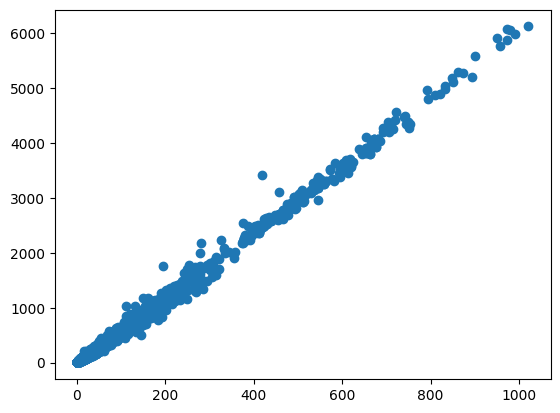

In [22]:
import matplotlib.pyplot as plt

p_skill = compute_skill_distrib(seq)
plt.scatter([len(x) for x in seq.values()], [entropy(x, p_skill) for x in seq.values()])

In [23]:
low_entropy = []
for i in seq.keys():
    if entropy(seq[i], p_skill) < 100:
        low_entropy.append(i)

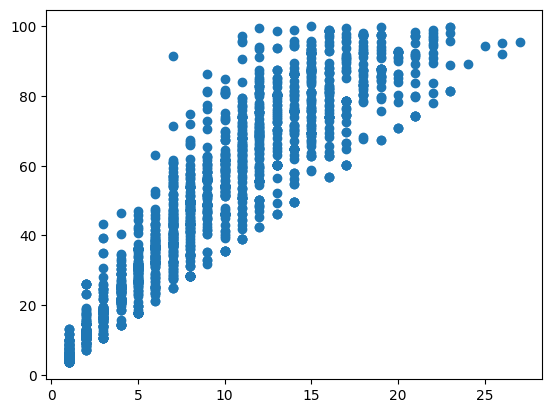

In [24]:
plt.scatter([len(seq[i]) for i in low_entropy], [entropy(seq[i], p_skill) for i in low_entropy])

We take 20 as the entropy limit to exclude all length 1 sequences

In [25]:
min(len(s[1]) for s in seq.items())

1

In [26]:
p_skill = compute_skill_distrib(seq)
users_tmp = list(seq.keys())
ent = [entropy(seq[user], p_skill) for user in users_tmp]
np.argmin(ent), ent[np.argmin(ent)], seq[users_tmp[np.argmin(ent)]]

(4003, 3.541580376805975, [(99, 1)])

(array([1.438e+03, 7.860e+02, 4.380e+02, 2.810e+02, 1.350e+02, 1.170e+02,
        1.090e+02, 7.900e+01, 8.500e+01, 5.800e+01, 4.600e+01, 4.900e+01,
        4.400e+01, 5.000e+01, 4.000e+01, 2.700e+01, 2.500e+01, 2.400e+01,
        2.100e+01, 1.500e+01, 1.300e+01, 1.400e+01, 9.000e+00, 1.000e+01,
        7.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 1.000e+01, 1.000e+00,
        3.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        7.000e+00, 3.000e+00, 7.000e+00, 1.000e+00, 7.000e+00, 4.000e+00,
        9.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 1.100e+01, 9.000e+00,
        8.000e+00, 1.000e+01, 6.000e+00, 7.000e+00, 3.000e+00, 5.000e+00,
        8.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 8.000e+00, 5.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 3.000e+00,
        7.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 6.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+0

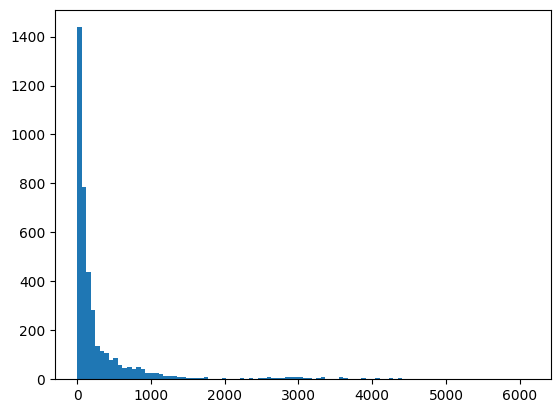

In [27]:
plt.hist(ent, bins=100)

In [28]:
# df_anon = anonymize(df_train, p=0.75)
score_roc_data = {}

In [29]:
dfs_comb = {}
# for spread in [-100, -10, -1, 0, 1, 10]:
for spread in [0]:
    dfs_comb[spread] = combine(df_train, spread=spread)

In [30]:
for score in [score_max]: # , score_sum, score_LogSumExp, score_prob, score_norm, score_norm10, score_median, score_mean]:
    print(score.__name__)
    # for norm in np.linspace(0, 10, 21):
    for norm in [9.7]: # range(6):
        if score.__name__+str(norm) in score_roc_data:
            continue
        fpr, tpr, thresholds = identify(seq, dfs_comb[0], score=lambda a, b: score(a, b, norm=norm))
        score_roc_data[score.__name__+str(norm)] = (fpr, tpr, thresholds)

score_max
0.9999999583771585


100%|█████████████████████████████████████████████████████████████| 3746/3746 [00:43<00:00, 87.00it/s]


In [31]:
roc_data_comb = {}

def compute_roc_comb(spread=0.0):
    if spread in roc_data_comb:
        return
    fpr, tpr, thresholds = identify(seq, dfs_comb[spread])
    roc_data_comb[spread] = (fpr, tpr, thresholds)

In [32]:
for spread in dfs_comb.keys():
    print(spread)
    compute_roc_comb(spread)

0
0.9999999583771585


100%|█████████████████████████████████████████████████████████████| 3746/3746 [00:44<00:00, 84.91it/s]


In [33]:
roc_data = {}

def compute_roc(p=0.5):
    if p in roc_data:
        return
    fpr, tpr, thresholds = identify(seq, anonymize(df_train, p=p))
    roc_data[p] = (fpr, tpr, thresholds)

In [34]:
for p in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
    print(p)
    compute_roc(p)

0
0.9999999583771585


100%|█████████████████████████████████████████████████████████████| 3746/3746 [00:44<00:00, 83.40it/s]


0.25
0.9999999583771585


100%|████████████████████████████████████████████████████████████| 3746/3746 [00:34<00:00, 108.41it/s]


0.5
0.9999999583771585


100%|████████████████████████████████████████████████████████████| 3746/3746 [00:26<00:00, 142.34it/s]


0.75
0.9999999583771585


100%|████████████████████████████████████████████████████████████| 3746/3746 [00:18<00:00, 201.29it/s]


0.99
0.9999999583771585


100%|████████████████████████████████████████████████████████████| 3746/3746 [00:04<00:00, 924.48it/s]


0.999
0.9999999583771585


100%|███████████████████████████████████████████████████████████| 3746/3746 [00:01<00:00, 2248.52it/s]


<IPython.core.display.Javascript object>


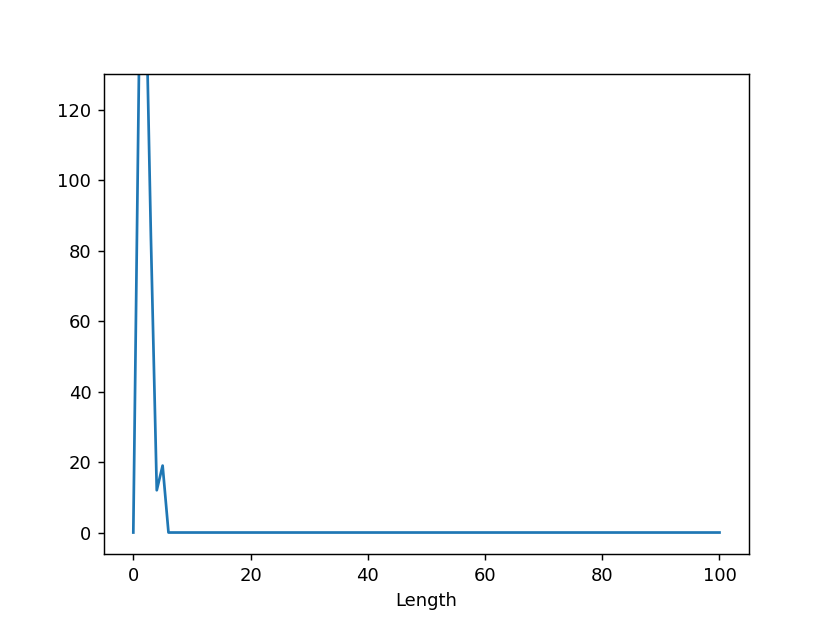

interactive(children=(FloatSlider(value=1.0, description='entl', max=2.0, min=-1.0), Output()), _dom_classes=(…

<function __main__.update(entl=1.0)>

In [35]:
%matplotlib notebook
from ipywidgets import *


def cnt_occ(l):
    d = [0] * 101
    for x in l:
        if x <= 100:
            d[x] += 1
    return d

# Create the figure and the line that we will manipulate
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

p_skill = compute_skill_distrib(seq)

line, = ax.plot(
    list(range(101)),
    cnt_occ(list(map(len, filter(lambda x: entropy(x, p_skill) < 10, seq.values()))))
)
ax.set_xlabel('Length')

def update(entl=1.0):
    line.set_ydata(
        cnt_occ(list(map(len, filter(lambda x: entropy(x, p_skill) < 10 ** entl, seq.values()))))
    )
    fig.canvas.draw_idle()

interact(update, entl=widgets.FloatSlider(min=-1, max=2, step=0.1, value=1))

In [40]:
p = df_train['user'].nunique() / len(seq)
entropy_limit = - (p * log2(p) + (1 - p) * log2(1 - p))

entropy_limit, log(2) / log(10)

(0.9999999583771585, 0.30102999566398114)

0: 0.908
0.25: 0.770
0.5: 0.674
0.75: 0.585
0.99: 0.503
0.999: 0.505


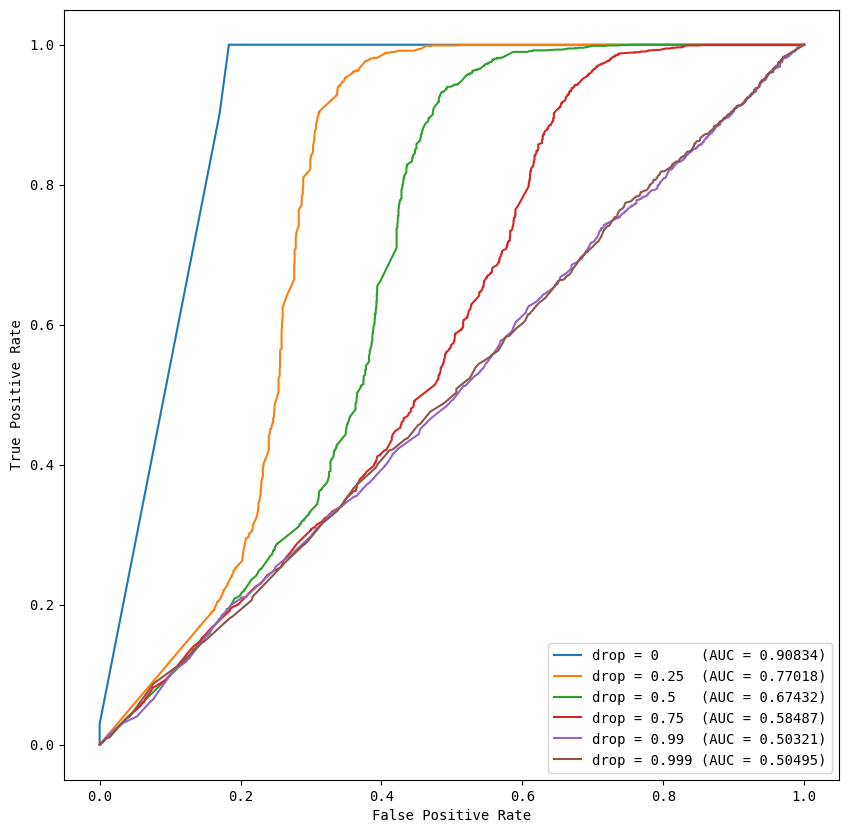

In [41]:
%matplotlib inline
from sklearn import metrics

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for p in roc_data.keys():
    (fpr, tpr, _) = roc_data[p]
    roc_auc = metrics.auc(fpr, tpr)
    print(f'{p}: {roc_auc:.3f}')
    plt.plot(fpr, tpr, label=f'drop = {p:<5} (AUC = {roc_auc:.5f})')

plt.legend()

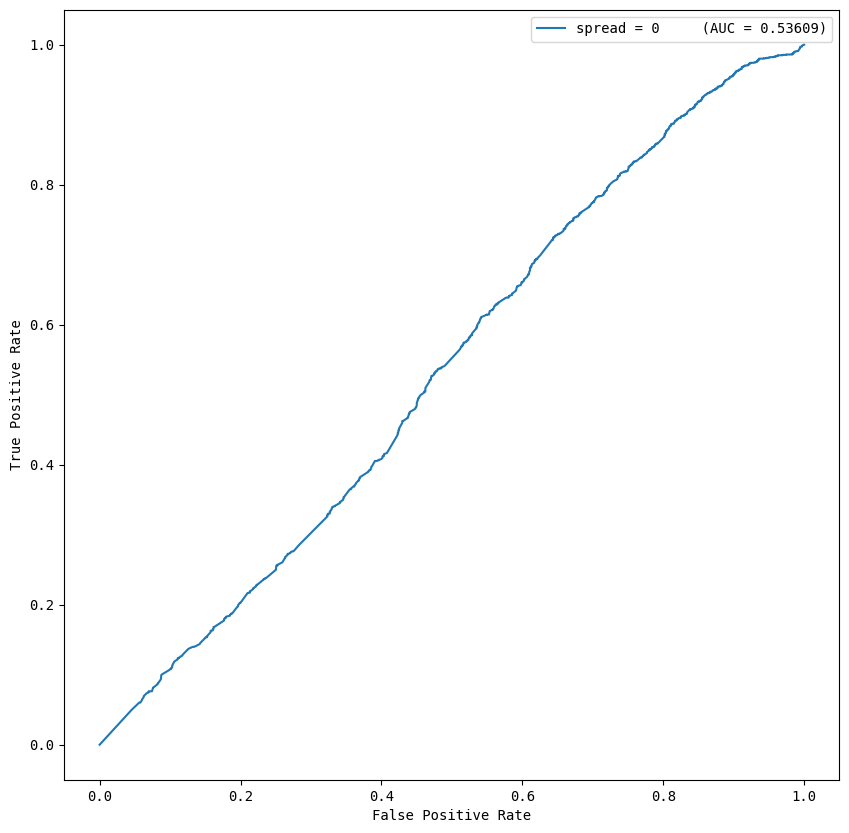

In [42]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for spread in roc_data_comb.keys():
    (fpr, tpr, _) = roc_data_comb[spread]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'spread = {spread:<5} (AUC = {roc_auc:.5f})')

plt.legend()

In [43]:
import re

aucs = []
X_aucs = []
for name in sorted(score_roc_data.keys()):
    (fpr, tpr, _) = score_roc_data[name]
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    X_aucs.append(float(re.findall(r"[-+]?(?:\d*\.\d+|\d+)", name)[0]))

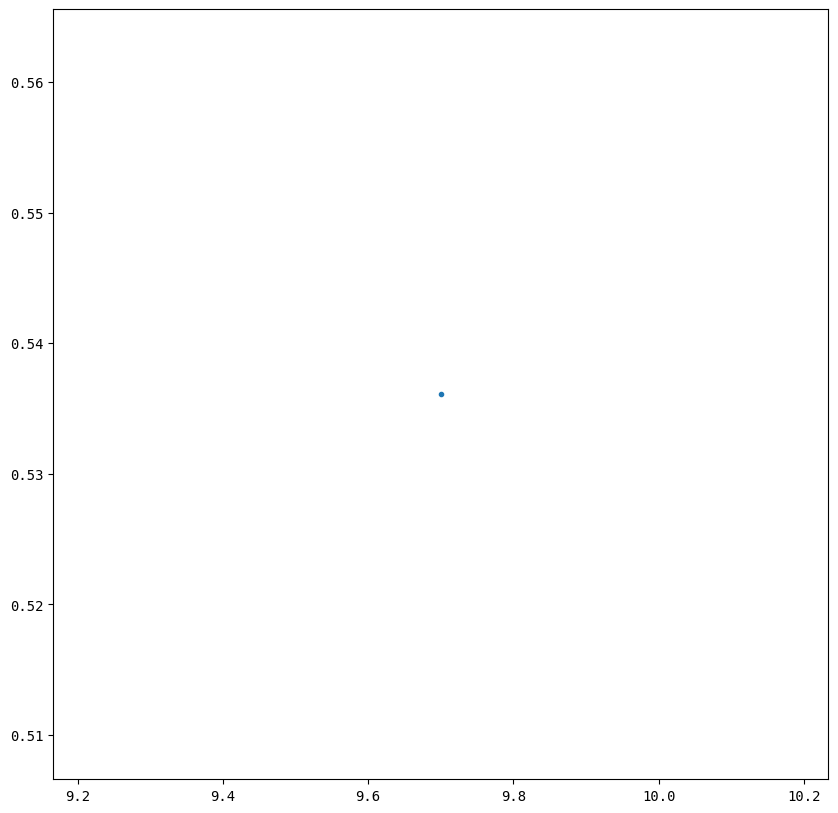

In [44]:
plt.plot(X_aucs, aucs, '.')

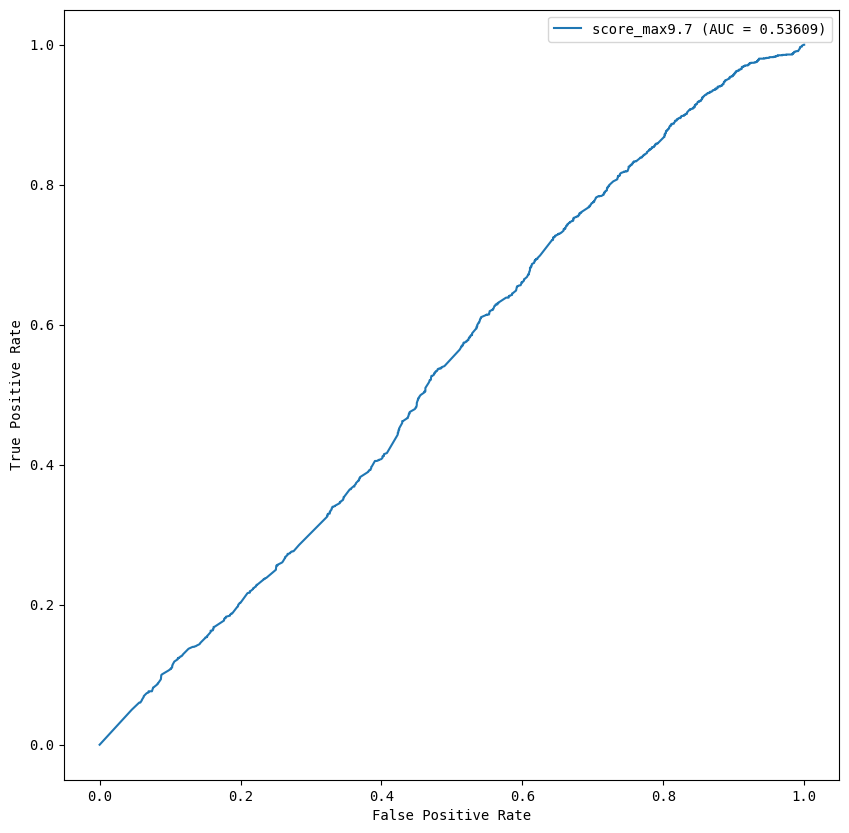

In [46]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# for name in sorted(list(filter(lambda name: len(name) > 10 and name[7] == 'a', list(score_roc_data.keys())))):
for name in sorted(score_roc_data.keys()):
    (fpr, tpr, _) = score_roc_data[name]
    roc_auc = metrics.auc(fpr, tpr)
    if roc_auc > 0.057:
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.5f})')

plt.legend()

In [47]:
lengths = np.array([len(s) for s in seq.values() if len(s)])

((array([311., 208., 293., 266.,  89., 260., 162., 185., 140., 139.]),
  array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
  <BarContainer object of 10 artists>),
 2053)

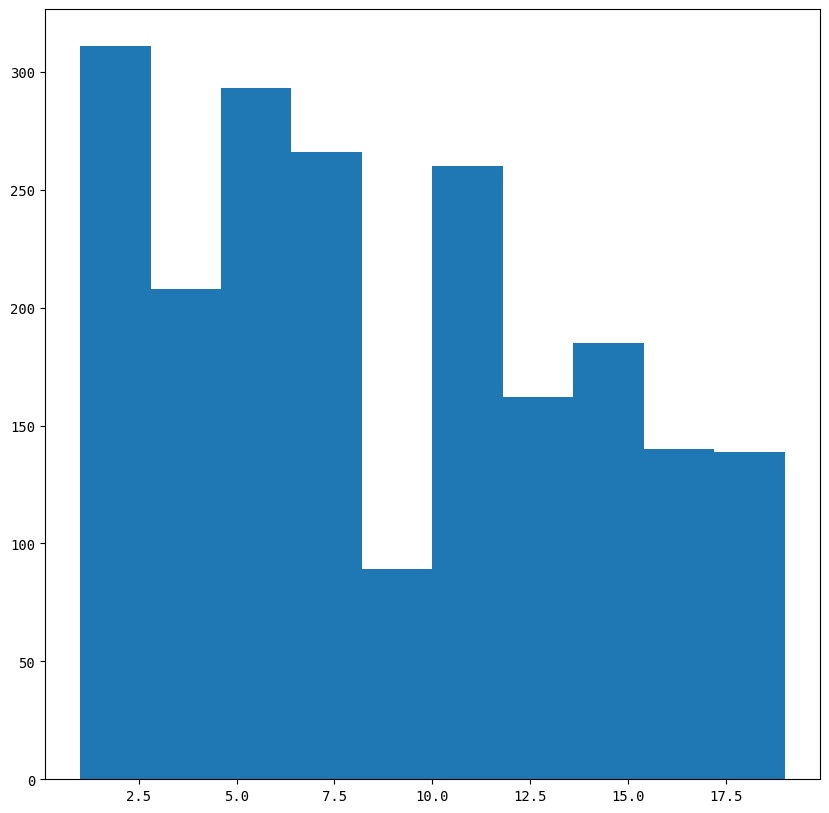

In [48]:
plt.hist(lengths[lengths < 20]), len(lengths[lengths < 20])

In [50]:
# df_train.to_csv(f'data/assistments2009train.csv', index=False)
if False:
    for drop in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        anonymize(df_train, p=drop).to_csv(f'../data/{dataset}_train/gen-drop{drop}.csv', index=False)

In [52]:
if dataset == 'duolingo':
    data_path_rnn = f'../data/{dataset}_train/gen-bsl-500-2-32-0.001-0-16-0-laststep.csv'
elif dataset == 'assistments2009':
    data_path_rnn = f'../data/{dataset}_train/gen-[20, 10, 5, 5]-100-1-16-0.001-0-256-0.csv'
else:
    assert(False)
data_path_hmm = f'../data/{dataset}_train/gen-markov.csv'

In [53]:
df_rnn = pd.read_csv(data_path_rnn)
df_hmm = pd.read_csv(data_path_hmm)

In [54]:
print(df_rnn.shape)
df_rnn.head()

(254648, 5)


,user,skill_id,skill,correct,theta
0,0,68,77,0,-1.00782
1,0,76,86,0,-1.00782
2,0,110,121,0,-1.00782
3,0,90,100,1,-1.00782
4,0,71,81,0,-1.00782


In [55]:
rnn_roc = identify(seq, df_rnn)

0.9999999583771585


100%|█████████████████████████████████████████████████████████████| 3746/3746 [01:06<00:00, 56.36it/s]


In [56]:
hmm_roc = identify(seq, df_hmm)

0.9999999583771585


100%|█████████████████████████████████████████████████████████████| 3746/3746 [00:41<00:00, 90.66it/s]


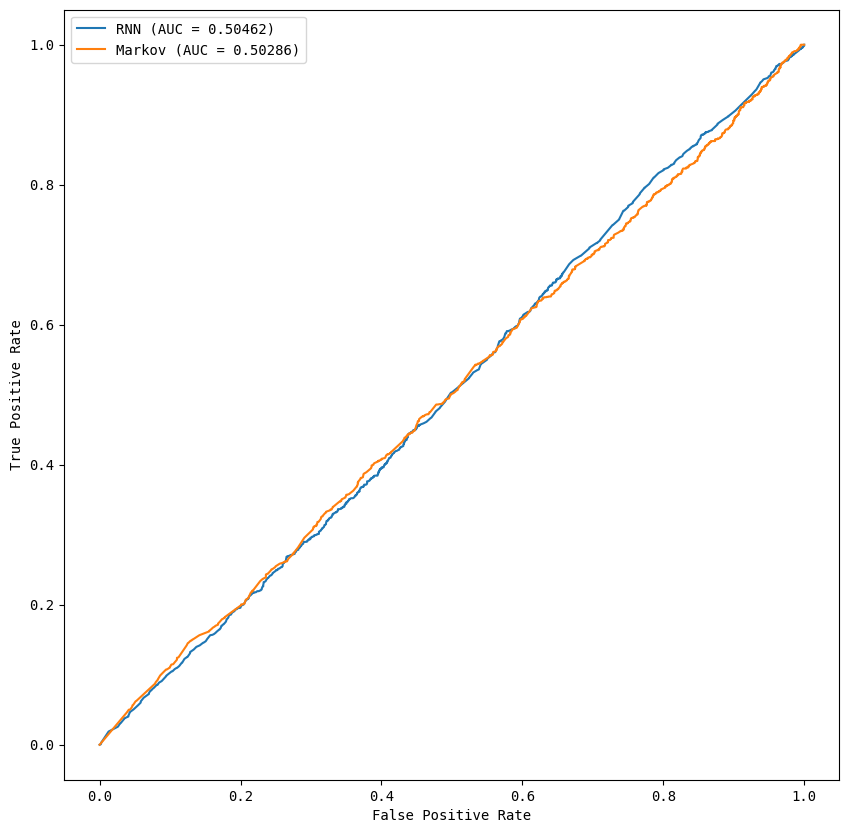

In [57]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for p in []: # [0, 0.25, 0.5, 0.99]:
    (fpr, tpr, _) = roc_data[p]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'drop = {p:<5} (AUC = {roc_auc:.5f})')
    
rnn_auc = metrics.auc(rnn_roc[0], rnn_roc[1]) # max3: 0.51466
plt.plot(rnn_roc[0], rnn_roc[1], label=f'RNN (AUC = {rnn_auc:.5f})')

hmm_auc = metrics.auc(hmm_roc[0], hmm_roc[1]) # max3: 0.51466
plt.plot(hmm_roc[0], hmm_roc[1], label=f'Markov (AUC = {hmm_auc:.5f})')

plt.legend()

In [58]:
# identify(seq, anonymize(df_train, p=0.5))

In [61]:
df.shape, df_rnn.shape, df_hmm.shape

((278607, 6), (254648, 5), (141760, 9))

In [62]:
max([user for user, _ in df_rnn.groupby('user')])

2080

In [69]:
base_lengths = df.groupby('user').size().reset_index().rename(columns={0: 'count'})['count']
rnn_lengths = df_rnn.groupby('user').size().reset_index().rename(columns={0: 'count'})['count']
hmm_lengths = df_hmm.groupby('user').size().reset_index().rename(columns={0: 'count'})['count']

In [72]:
base_ml = base_lengths.max()
rnn_ml = rnn_lengths.max()
hmm_ml = hmm_lengths.max()
base_ml, rnn_ml, hmm_ml

(1021, 837, 495)

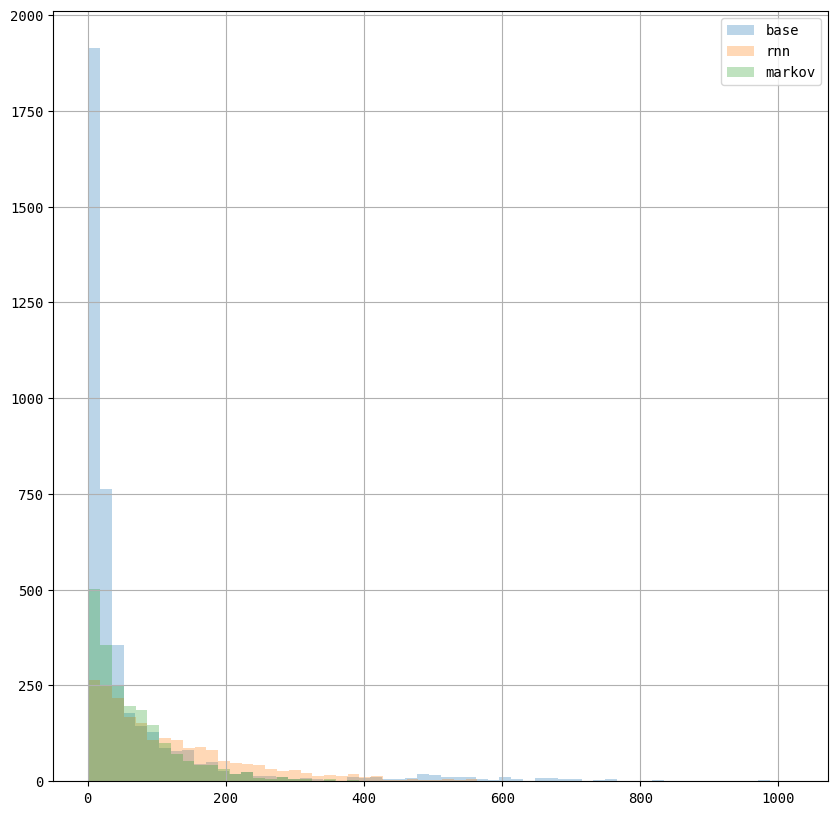

In [73]:
base_lengths.hist(bins=60, label='base', alpha=0.3)
rnn_lengths.hist(bins=int(60 * rnn_ml / base_ml), label='rnn', alpha=0.3)
hmm_lengths.hist(bins=int(60 * hmm_ml / base_ml), label='markov', alpha=0.3)
plt.legend()